In [8]:
#Load & Preprocess Dataset

Found 201 images belonging to 3 classes.
Found 50 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


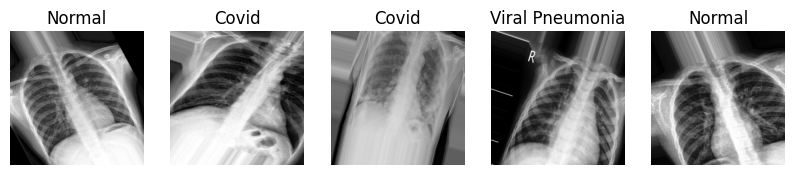

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Dataset Paths
dataset_path = "C:\\Users\\Harima\\Downloads\\lung\\Covid19-dataset"  # Change to your dataset location
train_dir = os.path.join(dataset_path, "train")
test_dir = os.path.join(dataset_path, "test")

# Image Properties
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Data Augmentation & Normalization
datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    validation_split=0.2,
    rotation_range=30, 
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Load Train, Validation, and Test Data
train_data = datagen.flow_from_directory(train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="categorical", subset="training")
val_data = datagen.flow_from_directory(train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="categorical", subset="validation")
test_data = datagen.flow_from_directory(test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="categorical")

# Show Sample Images with Class Names
x_batch, y_batch = next(train_data)
class_labels = list(train_data.class_indices.keys())  # Get class names

fig, axes = plt.subplots(1, 5, figsize=(10, 5))
for i, ax in enumerate(axes):
    ax.imshow(x_batch[i])
    ax.set_title(class_labels[y_batch[i].argmax()])  # Print class name
    ax.axis("off")
plt.show()


In [ ]:
#Load Pretrained VGG19 & Build Model
#We use VGG19 as the feature extractor, freeze the early layers, and train only the top layers.

In [14]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Load Pretrained VGG19 Model (without top layers)
base_model = VGG19(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze Initial Layers to Use Pretrained Features
for layer in base_model.layers[:-4]:  
    layer.trainable = False  # Freeze all but last 4 layers for fine-tuning

# Build Model
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation="relu"),
    Dropout(0.5),
    Dense(3, activation="softmax")  # 3 classes: Covid, Normal, Pneumonia
])

# Compile Model
model.compile(optimizer=Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])

# Learning Rate Scheduler (Reduce LR if no improvement)
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.5, verbose=1)


In [ ]:
#Train the Model
#We train only the last few layers, which helps avoid overfitting on small datasets.

In [15]:
# Train Model
history = model.fit(train_data, validation_data=val_data, epochs=20, callbacks=[lr_scheduler])

# Save Model
model.save("vgg19_pneumonia_model.h5")


Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 75s 11s/step - accuracy: 0.4659 - loss: 1.3365 - val_accuracy: 0.7000 - val_loss: 0.7820 - learning_rate: 1.0000e-04
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 67s 10s/step - accuracy: 0.6603 - loss: 0.7682 - val_accuracy: 0.7600 - val_loss: 0.6551 - learning_rate: 1.0000e-04
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 67s 10s/step - accuracy: 0.8193 - loss: 0.4929 - val_accuracy: 0.7600 - val_loss: 0.6013 - learning_rate: 1.0000e-04
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 68s 10s/step - accuracy: 0.8727 - loss: 0.3093 - val_accuracy: 0.8200 - val_loss: 0.4823 - learning_rate: 1.0000e-04
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 70s 10s/step - accuracy: 0.8999 - loss: 0.2821 - val_accuracy: 0.7400 - val_loss: 0.5544 - learning_rate: 1.0000e-04
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 67s 11s/step - accuracy: 0.8331 - loss: 0.4054 - val_accuracy: 0.8200 - val_loss: 0.4087 - learning_rate: 1.0000e-04
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 70s 10s/step - accuracy: 0.9068 - loss: 0.2573

In [16]:
#Step 4: Evaluate Model & Plot Performance

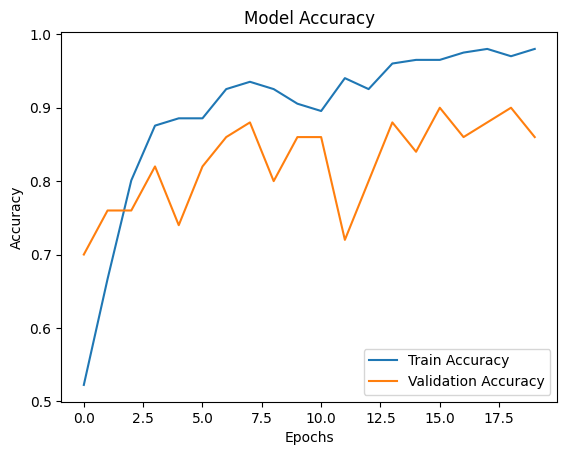

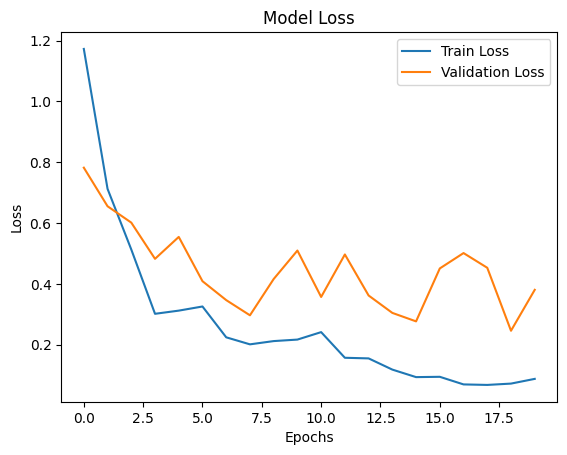

In [17]:
import matplotlib.pyplot as plt

# Plot Training & Validation Accuracy
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Model Accuracy")
plt.show()

# Plot Training & Validation Loss
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Model Loss")
plt.show()


In [18]:
#Step 5: Confusion Matrix & ROC Curve

c:\Users\RIYA\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 18s 5s/step


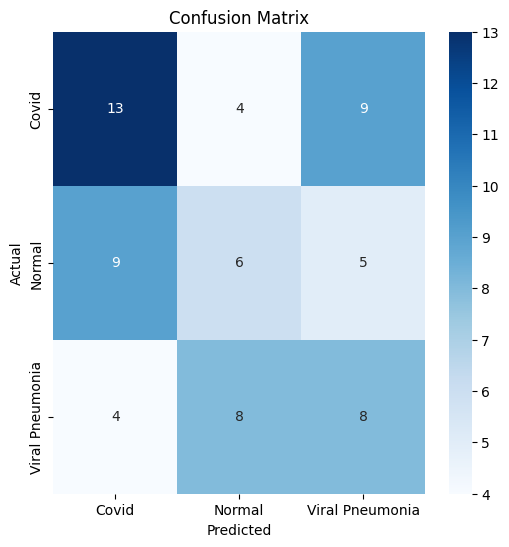

                 precision    recall  f1-score   support

          Covid       0.50      0.50      0.50        26
         Normal       0.33      0.30      0.32        20
Viral Pneumonia       0.36      0.40      0.38        20

       accuracy                           0.41        66
      macro avg       0.40      0.40      0.40        66
   weighted avg       0.41      0.41      0.41        66



In [19]:
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Predict on Test Data
y_pred = model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
y_true = test_data.classes  # Get true class labels

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print(classification_report(y_true, y_pred_classes, target_names=class_labels))


In [ ]:
# Higher capacity (Dense 512 → 256) – model can learn more expressive features.

#BatchNormalization – stabilizes and accelerates training.

# Regularization – helps reduce overfitting.

# Dropout used properly twice – better generalization.

#Fully frozen base – avoids overfitting small data by not training VGG weights.

In [32]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.applications import VGG19

# Load VGG19 model without the top layers
base_model = VGG19(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the convolutional base

# Build new model on top
x = Flatten()(base_model.output)
x = Dense(512, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = BatchNormalization()(x)  # Normalize activations
x = Dropout(0.5)(x)  # Dropout layer to reduce overfitting
x = Dense(256, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = Dropout(0.5)(x)
x = Dense(3, activation="softmax")(x)  # Connect output to previous layer

# Define the model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss="categorical_crossentropy",  # ✅ Use categorical loss
              metrics=["accuracy"])


# Summary of the new model
model.summary()


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 512)            │         2,04

 Total params: 33,004,099 (125.90 MB)

 Trainable params: 12,978,691 (49.51 MB)

 Non-trainable params: 20,025,408 (76.39 MB)

In [33]:
history = model.fit(
    train_data, 
    validation_data=val_data, 
    epochs=20,  # Adjust based on performance
    batch_size=32,
    verbose=1
)


Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 72s 10s/step - accuracy: 0.5130 - loss: 2.7043 - val_accuracy: 0.4400 - val_loss: 2.1963
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 65s 10s/step - accuracy: 0.8187 - loss: 1.7168 - val_accuracy: 0.5800 - val_loss: 2.0337
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 62s 9s/step - accuracy: 0.7963 - loss: 1.7037 - val_accuracy: 0.5600 - val_loss: 2.0217
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 62s 9s/step - accuracy: 0.9186 - loss: 1.3564 - val_accuracy: 0.4800 - val_loss: 2.0072
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 62s 9s/step - accuracy: 0.8749 - loss: 1.4145 - val_accuracy: 0.4800 - val_loss: 1.9687
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 65s 9s/step - accuracy: 0.9462 - loss: 1.2460 - val_accuracy: 0.4600 - val_loss: 1.9941
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 66s 9s/step - accuracy: 0.9173 - loss: 1.3096 - val_accuracy: 0.6000 - val_loss: 1.7605
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 77s 12s/step - accuracy: 0.9279 - loss: 1.2112 - val_accuracy: 0.6600 - val_loss: 1.7057
Epoch

In [34]:
# Print final training and validation accuracy
final_train_acc = history.history["accuracy"][-1]  # Last epoch's training accuracy
final_val_acc = history.history["val_accuracy"][-1]  # Last epoch's validation accuracy

print(f"Final Training Accuracy: {final_train_acc * 100:.2f}%")
print(f"Final Validation Accuracy: {final_val_acc * 100:.2f}%")


Final Training Accuracy: 97.51%
Final Validation Accuracy: 94.00%


In [35]:
test_loss, test_acc = model.evaluate(test_data)
print(f"Final Test Accuracy: {test_acc * 100:.2f}%")


3/3 ━━━━━━━━━━━━━━━━━━━━ 25s 6s/step - accuracy: 0.8847 - loss: 1.0864
Final Test Accuracy: 87.88%


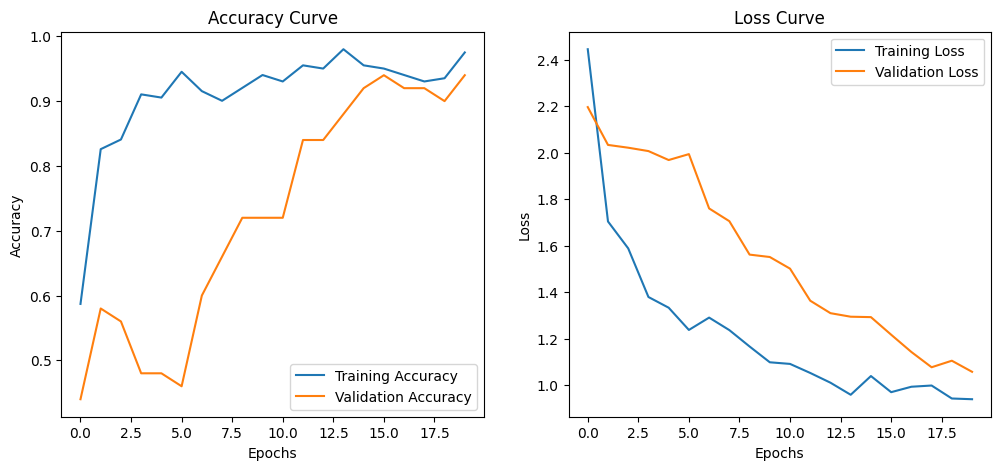

In [36]:
# Plot Accuracy & Loss Curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curve")

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")
plt.show()


In [ ]:
#Predict class

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Load and preprocess the image
img_path = "C:\\Users\\Harima\\Downloads\\lung\\Covid19-dataset\\test\\Normal\\0114.jpeg"
img = image.load_img(img_path, target_size=(224, 224))  # Load image
img_array = image.img_to_array(img)  # Convert to array
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.0  # Normalize

# Predict class
prediction = model.predict(img_array)
predicted_class = np.argmax(prediction, axis=1)[0]  # Get class index

# Get class labels from training data generator
class_indices = train_data.class_indices  # Dictionary mapping class names to indices
class_labels = {v: k for k, v in class_indices.items()}  # Reverse mapping

# Print prediction
print(f"Predicted Class: {class_labels[predicted_class]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step
Predicted Class: Normal


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step
Image 1:
  Actual Class: Viral Pneumonia
  Predicted Class: Viral Pneumonia
----------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step
Image 2:
  Actual Class: Covid
  Predicted Class: Covid
----------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step
Image 3:
  Actual Class: Normal
  Predicted Class: Normal
----------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step
Image 4:
  Actual Class: Covid
  Predicted Class: Covid
----------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step
Image 5:
  Actual Class: Covid
  Predicted Class: Covid
----------------------------------------


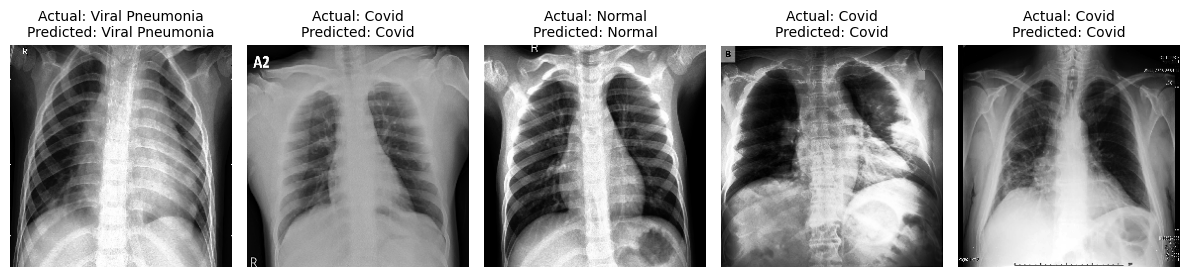

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Path to test dataset
test_dir = "C:\\Users\\Harima\\Downloads\\lung\\Covid19-dataset\\test"

# Get list of classes (folders in test directory)
class_folders = os.listdir(test_dir)

# Select 5 random images from different classes
num_images = 5
selected_images = []

for _ in range(num_images):
    # Randomly select a class
    random_class = random.choice(class_folders)
    class_path = os.path.join(test_dir, random_class)

    # Get list of images in the selected class
    image_files = os.listdir(class_path)

    # Randomly select an image
    random_image = random.choice(image_files)
    image_path = os.path.join(class_path, random_image)

    # Store selected image details
    selected_images.append((image_path, random_class))

# Plot the 5 images with predictions
plt.figure(figsize=(12, 6))

for i, (image_path, actual_class_name) in enumerate(selected_images):
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(224, 224))  # Load image
    img_array = image.img_to_array(img)  # Convert to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize

    # Make prediction
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]  # Get predicted index

    # Get class labels from training data
    class_indices = train_data.class_indices  # Dictionary mapping class names to indices
    class_labels = {v: k for k, v in class_indices.items()}  # Reverse mapping

    # Get predicted class name
    predicted_class_name = class_labels[predicted_class]

    # Display the image with actual vs predicted label
    plt.subplot(1, num_images, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Actual: {actual_class_name}\nPredicted: {predicted_class_name}", fontsize=10, color="black")

    # Print results
    print(f"Image {i+1}:")
    print(f"  Actual Class: {actual_class_name}")
    print(f"  Predicted Class: {predicted_class_name}")
    print("-" * 40)

plt.tight_layout()
plt.show()


In [ ]:
#confusion matrix  &  roc curve

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

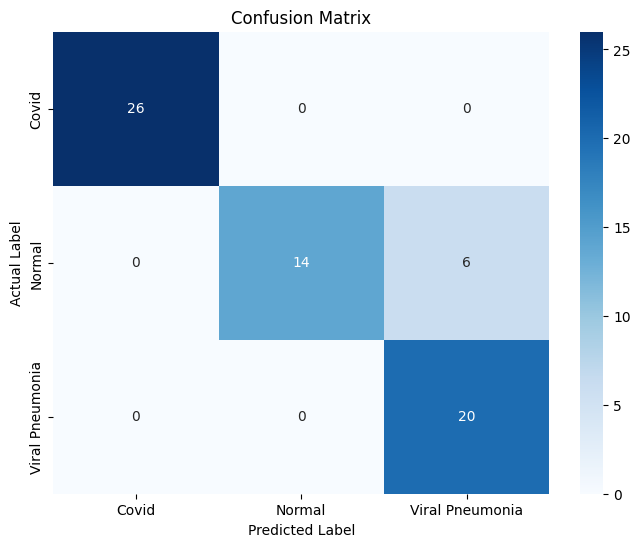

Classification Report:
                 precision    recall  f1-score   support

          Covid       1.00      1.00      1.00        26
         Normal       1.00      0.70      0.82        20
Viral Pneumonia       0.77      1.00      0.87        20

       accuracy                           0.91        66
      macro avg       0.92      0.90      0.90        66
   weighted avg       0.93      0.91      0.91        66



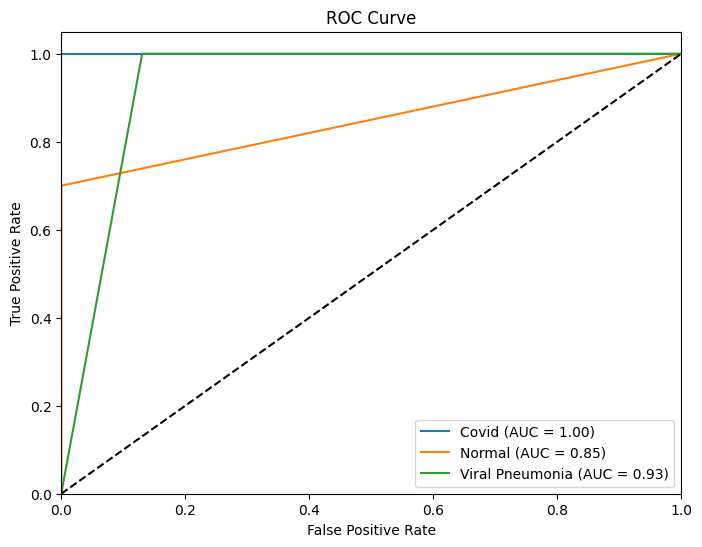

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from tensorflow.keras.preprocessing import image

# Path to test dataset
test_dir = "C:\\Users\\Harima\\Downloads\\lung\\Covid19-dataset\\test"

# Get list of class labels
class_folders = os.listdir(test_dir)
class_labels = {i: class_folders[i] for i in range(len(class_folders))}  # Mapping indices to class names

# Prepare true labels and predicted labels
true_labels = []
pred_labels = []
pred_probabilities = []

# Loop through test dataset to make predictions
for class_index, class_name in enumerate(class_folders):
    class_path = os.path.join(test_dir, class_name)
    image_files = os.listdir(class_path)

    for img_file in image_files:
        img_path = os.path.join(class_path, img_file)

        # Load and preprocess image
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize

        # Predict
        prediction = model.predict(img_array)
        predicted_class = np.argmax(prediction, axis=1)[0]
        predicted_prob = prediction[0][predicted_class]

        # Store results
        true_labels.append(class_index)  # Actual label (index of class)
        pred_labels.append(predicted_class)  # Predicted label
        pred_probabilities.append(predicted_prob)  # Predicted probability

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)
pred_probabilities = np.array(pred_probabilities)

# Generate Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels.values(), yticklabels=class_labels.values())
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix")
plt.show()

# Print Classification Report
print("Classification Report:")
print(classification_report(true_labels, pred_labels, target_names=class_labels.values()))

# Compute ROC Curve for each class
plt.figure(figsize=(8, 6))
for i in range(len(class_labels)):
    fpr, tpr, _ = roc_curve((true_labels == i).astype(int), (pred_labels == i).astype(int))
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_labels[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--")  # Diagonal line (random guessing)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()


In [ ]:
#FEATURE MAP

574710816/574710816 ━━━━━━━━━━━━━━━━━━━━ 475s 1us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


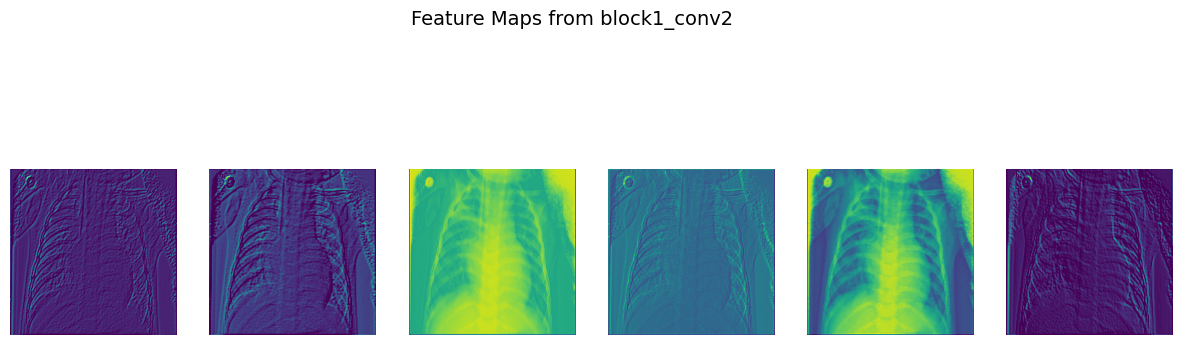

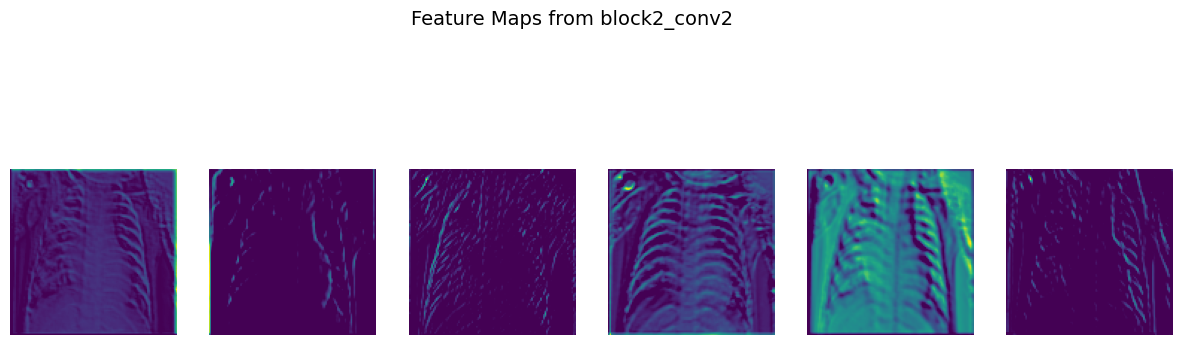

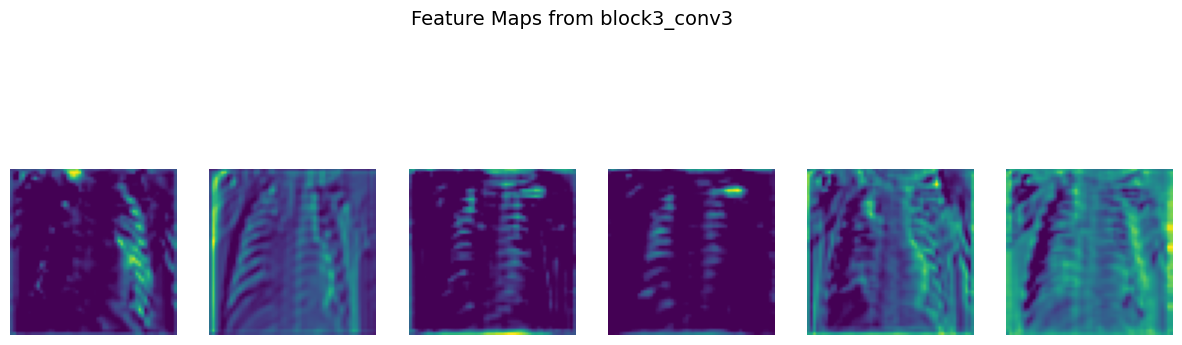

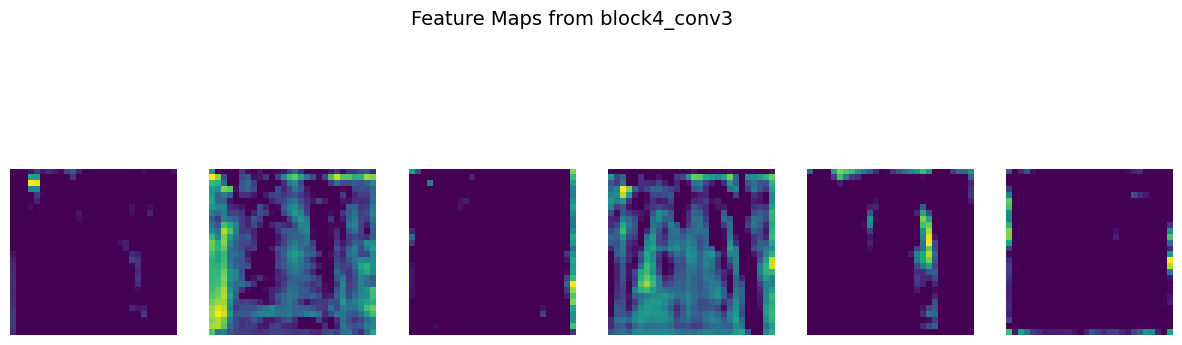

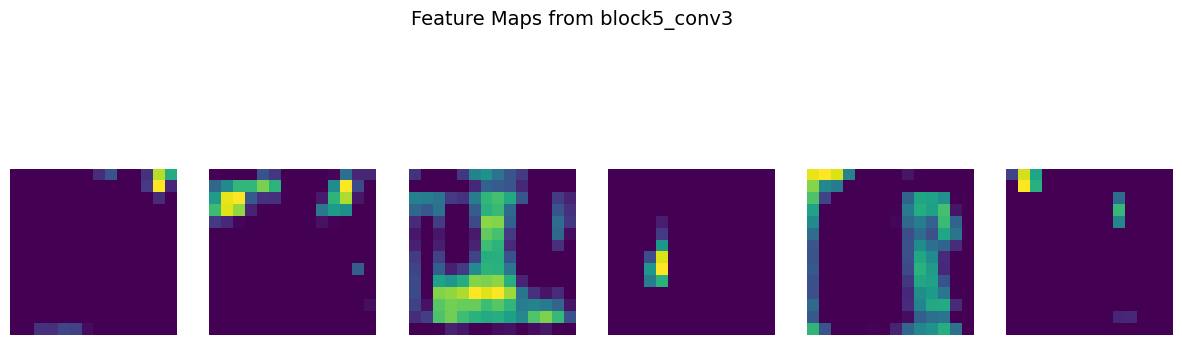

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

# Load Pretrained VGG19 Model
model = VGG19(weights='imagenet')  # If using a trained model, replace with your model

# Select Layers to Visualize Feature Maps
layer_names = ["block1_conv2", "block2_conv2", "block3_conv3", "block4_conv3", "block5_conv3"]
layer_outputs = [model.get_layer(name).output for name in layer_names]

# Create Model to Extract Feature Maps
feature_model = Model(inputs=model.input, outputs=layer_outputs)

# Load and Preprocess Image
img_path = "C:\\Users\\Harima\\Downloads\\lung\\Covid19-dataset\\test\\Viral Pneumonia\\0102.jpeg"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0  # Normalize
img_array = np.expand_dims(img_array, axis=0)

# Get Feature Maps
feature_maps = feature_model.predict(img_array)

# Plot Feature Maps for Each Layer
for layer_name, feature_map in zip(layer_names, feature_maps):
    num_filters = feature_map.shape[-1]  # Get number of filters
    fig, axes = plt.subplots(1, min(num_filters, 6), figsize=(15, 5))  # Show max 6 feature maps
    fig.suptitle(f"Feature Maps from {layer_name}", fontsize=14)

    for i in range(min(num_filters, 6)):  # Display 6 feature maps per layer
        ax = axes[i]
        ax.imshow(feature_map[0, :, :, i], cmap="viridis")
        ax.axis("off")

    plt.show()


In [ ]:
#LIME

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 

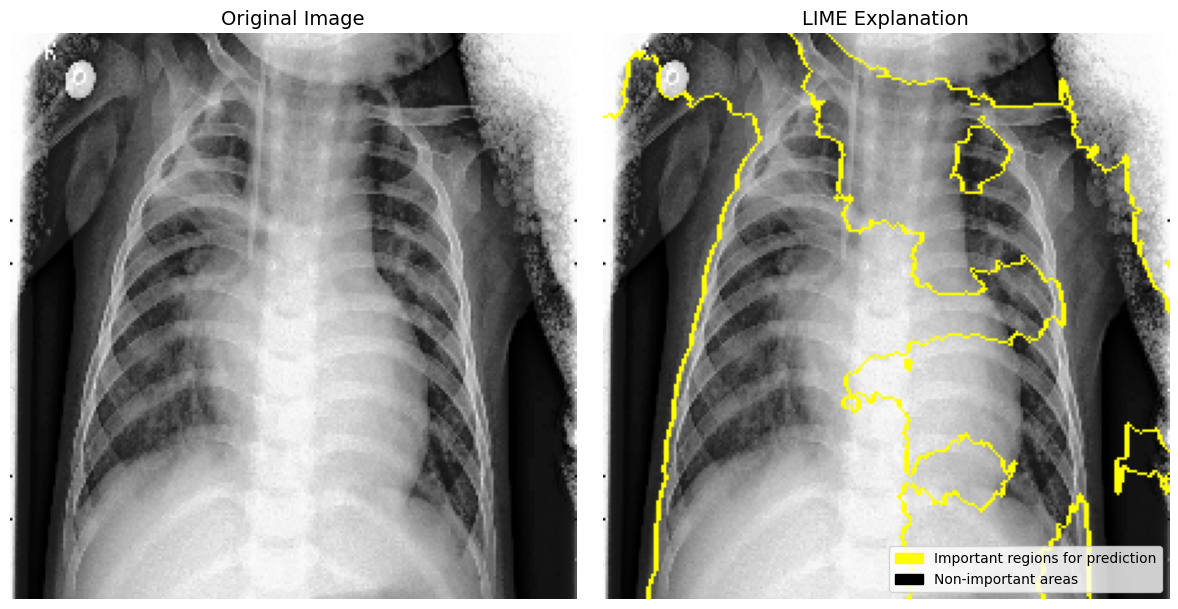

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries
from tensorflow.keras.preprocessing import image
import matplotlib.patches as mpatches

# ✅ Step 1: Load the Original Image
img_path = "C:\\Users\\Harima\\Downloads\\lung\\Covid19-dataset\\test\\Viral Pneumonia\\0102.jpeg"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# ✅ Step 2: Initialize LIME Explainer
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(img_array[0], model.predict, top_labels=1, hide_color=0, num_samples=1000)

# ✅ Step 3: Get Explanation Mask
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=False)

# ✅ Step 4: Plot Original & LIME Explanation Side by Side
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# 🔹 Left: Original Image
ax[0].imshow(img)
ax[0].axis("off")
ax[0].set_title("Original Image", fontsize=14)

# 🔹 Right: LIME Explanation
ax[1].imshow(mark_boundaries(temp, mask))
ax[1].axis("off")
ax[1].set_title("LIME Explanation", fontsize=14)

# ✅ Step 5: Add a Legend
legend_patches = [
    mpatches.Patch(color='yellow', label="Important regions for prediction"),
    mpatches.Patch(color='black', label="Non-important areas")
]
ax[1].legend(handles=legend_patches, loc="lower right", fontsize=10)

plt.tight_layout()  # Adjust layout for better spacing
plt.show()


Grad-CAM features saved to gradcam_features.npy


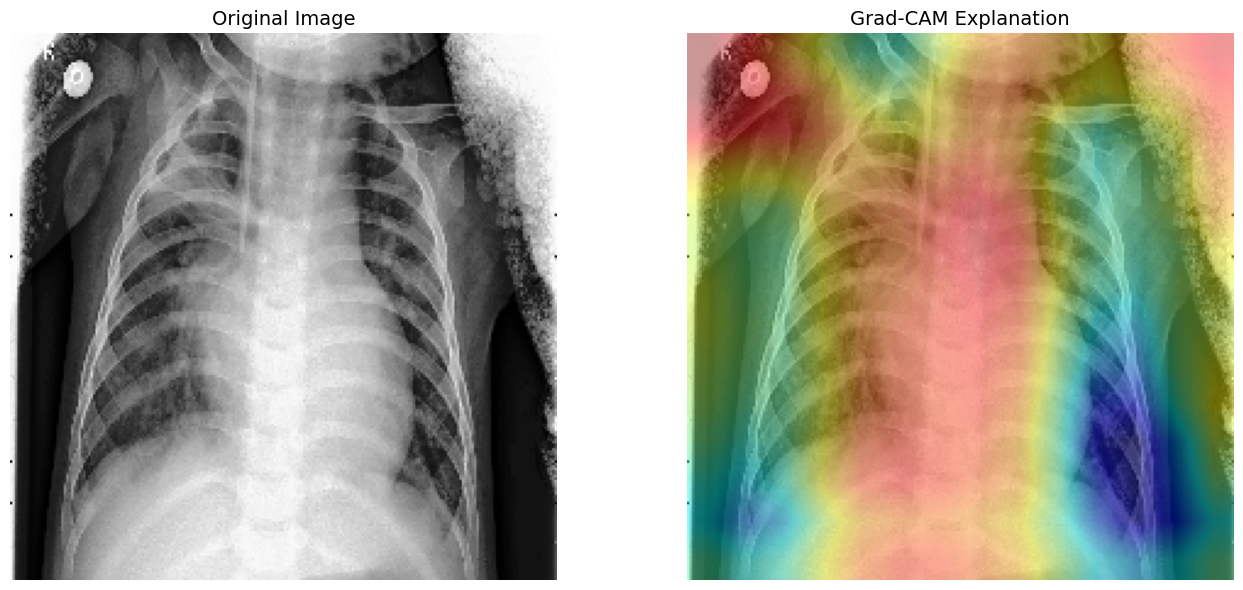

In [ ]:
#GRADCAM
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# ✅ Step 1: Load & Preprocess the Image
image_path = "C:\\Users\\Harima\\Downloads\\lung\\Covid19-dataset\\test\\Viral Pneumonia\\0102.jpeg"  # 🔹 Change this to your actual image path
img = load_img(image_path, target_size=(224, 224))  # Resize to match model input
img_array = img_to_array(img) / 255.0  # Normalize to [0,1] range
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# ✅ Step 2: Define the Grad-CAM Model
# Selecting the last convolutional layer in VGG19
grad_model = Model(inputs=model.input, outputs=[model.get_layer("block5_conv4").output, model.output])

# ✅ Step 3: Compute Gradients
with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(img_array)
    class_index = np.argmax(predictions)  # Get predicted class
    loss = predictions[:, class_index]  # Extract confidence for that class

# Compute gradients of the output with respect to conv layer activations
grads = tape.gradient(loss, conv_outputs)[0]

# ✅ Step 4: Compute Importance Weights
weights = np.mean(grads, axis=(0, 1))  # Global average pooling

# ✅ Step 5: Compute Grad-CAM Heatmap
heatmap = np.dot(conv_outputs[0], weights)  # Weighted sum of feature maps
heatmap = np.maximum(heatmap, 0)  # ReLU activation (removes negatives)
heatmap /= np.max(heatmap)  # Normalize between 0 and 1

# ✅ **Step 6: Save Features as .npy File**
feature_filename = "gradcam_features.npy"
np.save(feature_filename, heatmap)  # Save the extracted Grad-CAM feature map
print(f"Grad-CAM features saved to {feature_filename}")

# ✅ Step 7: Overlay Heatmap on Original Image
heatmap_resized = cv2.resize(heatmap, (224, 224))  # Resize to match input image
heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)

# Convert original image back to 8-bit format
img_original = (img_array[0] * 255).astype(np.uint8)

# Superimpose heatmap onto the original image
superimposed_img = cv2.addWeighted(img_original, 0.6, heatmap_colored, 0.4, 0)

# ✅ Step 8: Display Both Original and Grad-CAM Image Side by Side
fig, ax = plt.subplots(1, 2, figsize=(14, 6))  # One row, two columns

# 🔹 Left: Original Image
ax[0].imshow(img_original)
ax[0].axis("off")
ax[0].set_title("Original Image", fontsize=14)

# 🔹 Right: Grad-CAM Output
ax[1].imshow(superimposed_img)
ax[1].axis("off")
ax[1].set_title("Grad-CAM Explanation", fontsize=14)

plt.tight_layout()
plt.show()


In [ ]:
#INTEGRATED GRADIENT

In [48]:
!pip install tf-explain



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
✅ Integrated Gradients features saved successfully!


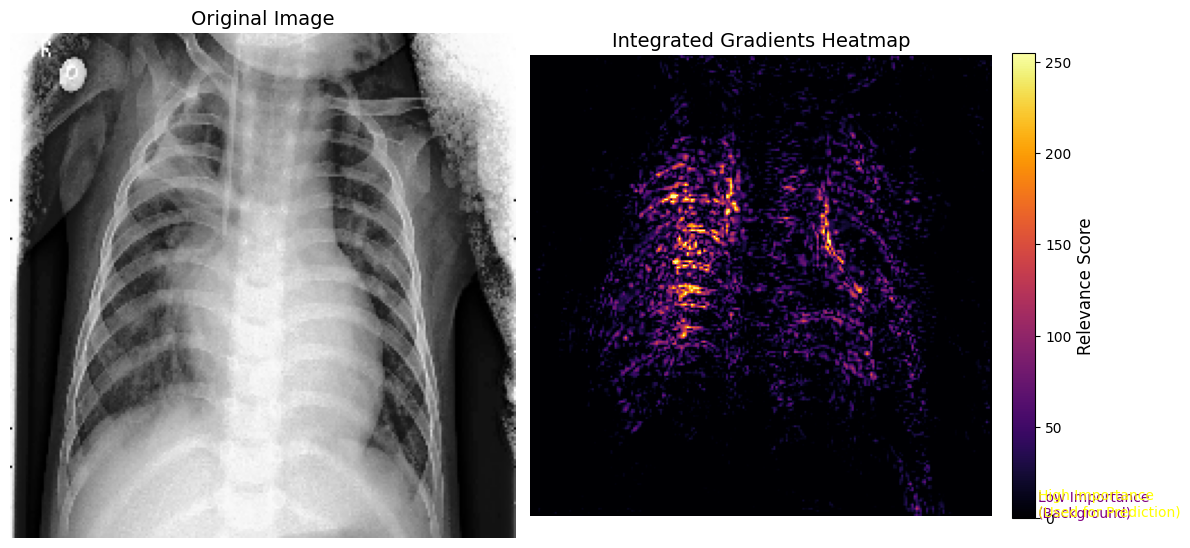

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tf_explain.core.integrated_gradients import IntegratedGradients
from tensorflow.keras.preprocessing import image

# ✅ Step 1: Load the Original Image
img_path = "C:\\Users\\Harima\\Downloads\\lung\\Covid19-dataset\\test\\Viral Pneumonia\\0102.jpeg"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0  # Normalize pixel values
img_array = np.expand_dims(img_array, axis=0)

# ✅ Step 2: Load Model and Get Prediction
model = tf.keras.models.load_model("vgg19_pneumonia_model.h5")  # Load your trained model
predictions = model.predict(img_array)
class_index = np.argmax(predictions)  # Get the class with the highest probability

# ✅ Step 3: Compute Integrated Gradients
explainer = IntegratedGradients()
explanation = explainer.explain((img_array, None), model, class_index)  # Generate explanation

# ✅ Step 4: Save the Features as `.npy` File
np.save("integrated_gradients_features.npy", explanation)  
print("✅ Integrated Gradients features saved successfully!")

# ✅ Step 5: Plot Original & Integrated Gradients Side by Side
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# 🔹 Left: Original Image
ax[0].imshow(img)
ax[0].axis("off")
ax[0].set_title("Original Image", fontsize=14)

# 🔹 Right: Integrated Gradients Heatmap with Color Legend
heatmap = ax[1].imshow(explanation, cmap="inferno")
ax[1].axis("off")
ax[1].set_title("Integrated Gradients Heatmap", fontsize=14)

# ✅ Add a Color Legend (Color Bar)
cbar = fig.colorbar(heatmap, ax=ax[1], fraction=0.046, pad=0.04)
cbar.set_label("Relevance Score", fontsize=12)

# 🔥 Define Meaning of Colors in the Heatmap
cbar.ax.text(1.1, 0.1, "Low Importance\n(Background)", ha="left", fontsize=10, color="purple")
cbar.ax.text(1.1, 0.9, "High Importance\n(Used for Prediction)", ha="left", fontsize=10, color="yellow")

plt.tight_layout()  # Adjust layout for better spacing
plt.show()


In [ ]:
#LRP

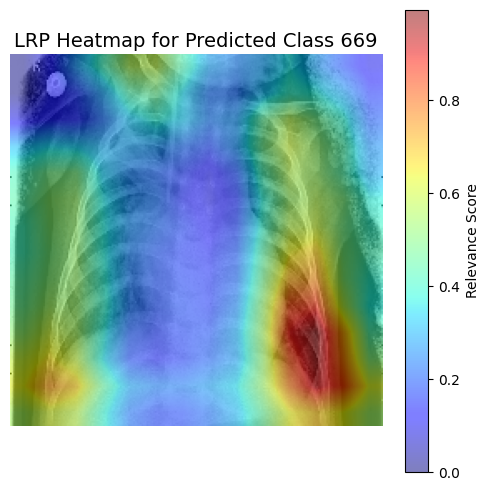

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

# Load Pretrained VGG19 Model (Modify if using a trained model)
model = VGG19(weights='imagenet')  # Change to your trained model if needed

# Select the Last Convolutional Layer for LRP
last_conv_layer_name = "block5_conv4"  # Last convolutional layer in VGG19

# Load and preprocess the image
img_path = "C:\\Users\\Harima\\Downloads\\lung\\Covid19-dataset\\test\\Viral Pneumonia\\0102.jpeg"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0  # Normalize
img_array = np.expand_dims(img_array, axis=0)

# Create a Model to Extract Feature Maps from the Last Conv Layer
grad_model = Model(
    inputs=model.input,
    outputs=[model.get_layer(last_conv_layer_name).output, model.output]
)

# Compute LRP
with tf.GradientTape() as tape:
    conv_output, predictions = grad_model(img_array)
    predicted_class = tf.argmax(predictions[0])  # Get the predicted class index
    loss = predictions[:, predicted_class]

# Compute Gradients
grads = tape.gradient(loss, conv_output)

# Apply Global Average Pooling (GAP) to Get Importance Per Filter
weights = tf.reduce_mean(grads, axis=(0, 1, 2))

# Compute LRP Relevance Map
lrp_map = np.dot(conv_output[0], weights.numpy().reshape(-1, 1))

# Normalize LRP Heatmap
lrp_map = np.maximum(lrp_map, 0)  # Remove negative values
lrp_map /= np.max(lrp_map)  # Normalize between 0 and 1

# Resize LRP Map to Match Image Size
lrp_map = tf.image.resize(lrp_map, (224, 224)).numpy()

# Display the Original Image with LRP Heatmap
plt.figure(figsize=(6, 6))
plt.imshow(img)  # Original Image
plt.imshow(lrp_map, cmap="jet", alpha=0.5)  # Overlay LRP Heatmap
plt.title(f"LRP Heatmap for Predicted Class {predicted_class}", fontsize=14)
plt.axis("off")
plt.colorbar(label="Relevance Score")
plt.show()


In [78]:
for layer in model.layers:
    if "conv" in layer.name.lower():  # Filters only conv layers
        print(layer.name)


block1_conv1
block1_conv2
block2_conv1
block2_conv2
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block5_conv1
block5_conv2
block5_conv3
block5_conv4


In [ ]:
#DECISION TREE

In [87]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
import joblib

# ✅ Load Saved Features
ig_features = np.load("integrated_gradients_features.npy").flatten().reshape(1, -1)
gradcam_features = np.load("gradcam_features.npy").flatten().reshape(1, -1)

# ✅ Combine Features for Training
X = np.concatenate((ig_features, gradcam_features), axis=1)

# ✅ Define Labels (Modify if you have multiple samples)
y = np.array([1])  # Example: 1 for Pneumonia, 0 for Normal (adjust as needed)

# ✅ Train Decision Tree Classifier
dt_model = DecisionTreeClassifier()
dt_model.fit(X, y)

# ✅ Save Trained Model
joblib.dump(dt_model, "decision_tree_model.pkl")
print("✅ Decision Tree model saved successfully!")


✅ Decision Tree model saved successfully!


In [88]:
# ✅ Load the Trained Decision Tree Model
dt_model = joblib.load("decision_tree_model.pkl")

# ✅ Make Prediction
prediction = dt_model.predict(X)
print("🔹 Predicted Class:", prediction)


🔹 Predicted Class: [1]


In [96]:
print("Grad-CAM Features Shape:", gradcam_features.shape)  
print("Integrated Gradients Features Shape:", ig_features.shape)


Grad-CAM Features Shape: (14, 14)
Integrated Gradients Features Shape: (224, 224)


In [97]:
num_samples = min(gradcam_features.shape[0], ig_features.shape[0])  # Find the smaller sample size

gradcam_features = gradcam_features[:num_samples]  # Trim excess rows
ig_features = ig_features[:num_samples]  # Trim excess rows

X = np.concatenate([gradcam_features, ig_features], axis=1)  # Now they match


In [98]:
ig_features = ig_features[:gradcam_features.shape[0], :]
X = np.concatenate([gradcam_features, ig_features], axis=1)



🌳 Decision Tree Structure (Text Format):

|--- Feature_126 <= 28.00
|   |--- Feature_10 <= 0.84
|   |   |--- Feature_120 <= 26.50
|   |   |   |--- class: 0
|   |   |--- Feature_120 >  26.50
|   |   |   |--- class: 1
|   |--- Feature_10 >  0.84
|   |   |--- class: 1
|--- Feature_126 >  28.00
|   |--- class: 2



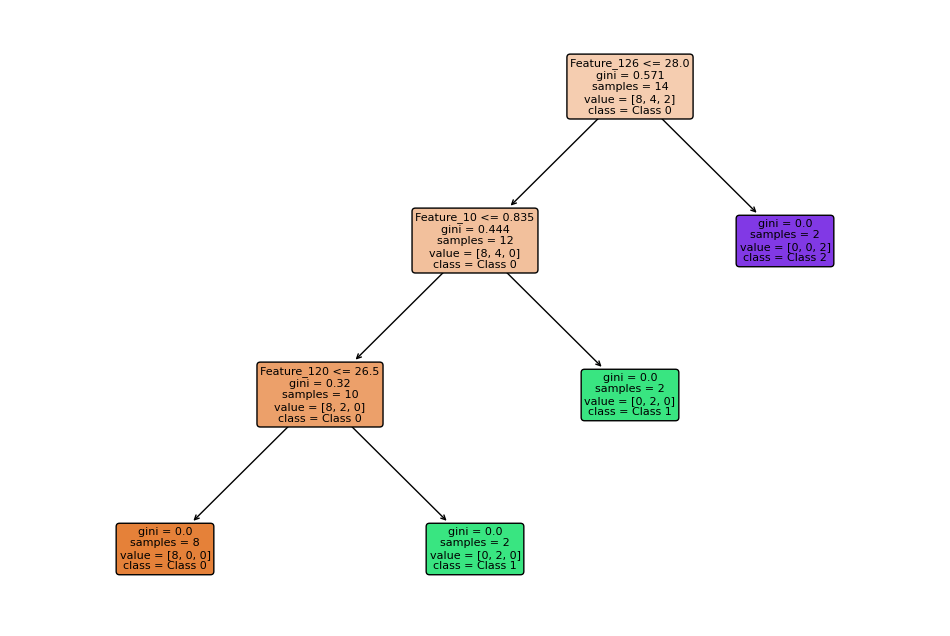

In [100]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree

# ✅ Step 1: Load Grad-CAM & Integrated Gradients Features
gradcam_features = np.load("gradcam_features.npy")  # (num_samples_1, num_features)
ig_features = np.load("integrated_gradients_features.npy")  # (num_samples_2, num_features)

# ✅ Step 2: Fix Shape Mismatch (Ensure Same Sample Size)
num_samples = min(gradcam_features.shape[0], ig_features.shape[0])  # Match smallest sample size
gradcam_features = gradcam_features[:num_samples]  # Trim excess rows
ig_features = ig_features[:num_samples]  # Trim excess rows

# ✅ Step 3: Combine Features into a Single Dataset
X = np.concatenate([gradcam_features, ig_features], axis=1)

# ✅ Step 4: Generate Fake Labels (Replace with real labels if available)
y = np.random.randint(0, 3, num_samples)  # Multi-class classification (0, 1, or 2)

# ✅ Step 5: Train Decision Tree Model for 3 Classes
dt_model = DecisionTreeClassifier(max_depth=4, random_state=42)
dt_model.fit(X, y)

# ✅ Step 6: Print Decision Tree as Text
tree_text = export_text(dt_model, feature_names=[f"Feature_{i}" for i in range(X.shape[1])])
print("\n🌳 Decision Tree Structure (Text Format):\n")
print(tree_text)

# ✅ Step 7: Plot Decision Tree Graph
plt.figure(figsize=(12, 8))
plot_tree(
    dt_model,
    feature_names=[f"Feature_{i}" for i in range(X.shape[1])],
    class_names=["Class 0", "Class 1", "Class 2"],  # Update for 3 classes
    filled=True,
    rounded=True,
    fontsize=8
)
plt.show()


In [102]:
class_names = train_data.class_indices  # Get class-to-index mapping
class_names = {v: k for k, v in class_names.items()}  # Reverse mapping to get index-to-class

print("Class names:", class_names)


Class names: {0: 'Covid', 1: 'Normal', 2: 'Viral Pneumonia'}
